# Simple Gaussian Process Classification steps 1-4
https://kenzaxtazi.github.io/testsite.io/framework/

# 1. Problem Definition
The Arctic ocean is dominated by sea ice-forming processes, tides and currents, that dictate the tranfer of heat and nutrients across the Arctic basins. However, due to the presense of sea ice, obtaining oceanographic data is very limited. An interpolation of the ocean characteristics, temperature, salinity and dissolved oxygen, can therefore provide insights into the presence of types of water masses within the Arctic. Moreover, their propagation throughout the seasons can provide insights into the Arctic physical processes.

In this notebook, we will classify oceanographic characteristics and will create a model that maps out their spatio-temporal extent.

Gaussian Process Classification is a good tool for Arctic research, due to its ability to deal with small numbers of datapoints. Good uncertainty quantification can also provide insights into potential regions of water mass mixing.

### Methods
The Gaussian Process Classifier is a probabilistic, non-parametric machine :learning method. It is particularly well-suited for classification tasks where the decision boundaries are complex and not easily defined by simple linear models. GPC models the data distribution using a Gaussian process, which allows it to capture non-linear relationships in the data.

We start of with a simpel RBF kernel.


### Workflow
- Data Preparation:

    We will load and preprocess the dataset, preparing it for model training and evaluation.
- Gaussian Process Classifier:

    We will create an instance of the Gaussian Process Classifier with an RBF kernel and train it on the preprocessed data.
- Model Evaluation:

    We will evaluate the performance of the GPC model by measuring its accuracy and other relevant metrics.
- Visualization:

    We will visualize the classification results, showcasing the regions on the Arctic map.


In [3]:
%%capture
!pip install cartopy

In [4]:
import sys
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import resample
sys.path.append("/Users/Lisanne/Documents/AI4ER/PhD/GPs")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import accuracy_score, classification_report
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Save the DataFrame to a pickle file
#merged_df = pd.read_pickle("/Users/Lisanne/Documents/AI4ER/PhD/GPs/data/processed/means2006.pkl")
mean_df = pd.read_pickle("/content/drive/MyDrive/ai4er/GPs/data/processed/ml_ready/coldwarmclass.pkl")

# 2. Initial Data Exploration
ITP and Argos data from 2006, 2007 and 2008 contain 269,671 datapoints.
For this interpolation task, the dimensionality D = 4, as we will use latitude, longitude, depth and time. We have N = 269671 collected datapoints.

In [7]:
mean_df

,conservative_temp,absolute_salinity,dissolved_oxygen,year,month,latitude,longitude,depth,WaterMass
76,-1.50255,27.54745,400.78785,2007.0,4.0,76.5532,-137.8500,5.0,NsCold
77,-1.50240,27.54772,400.92625,2007.0,4.0,76.5532,-137.8500,15.0,NsCold
78,-1.50306,27.57359,401.02269,2007.0,4.0,76.5532,-137.8500,25.0,NsCold
79,-1.46331,27.82777,399.67352,2007.0,4.0,76.5532,-137.8500,35.0,NsCold
80,-1.01075,29.43891,388.21348,2007.0,4.0,76.5532,-137.8500,45.0,NsCold
...,...,...,...,...,...,...,...,...,...
1291783,1.21790,34.88800,302.20000,2007.0,9.0,83.9110,-1.6817,342.0,SaltyWarm
1291784,1.00710,34.88600,302.50000,2007.0,9.0,83.9110,-1.6817,396.0,SaltyWarm
1291785,0.62370,34.87900,305.20000,2007.0,9.0,83.9110,-1.6817,494.0,SaltyWarm
1291786,0.11900,34.87500,307.80000,2007.0,9.0,83.9110,-1.6817,692.0,SaltyCold


### Balance dataframe
We then get equal amounts of data points for each class, considering some classes are massively oversampled. We are then left with N =
3836 datapoints.

In [39]:
mean_df.WaterMass.value_counts()

SaltyWarm    157361
SaltyCold     58760
NsCold        52591
NsWarm          959
Name: WaterMass, dtype: int64

In [11]:
# Count the occurrences of each class in the "WaterMass" column
class_counts = mean_df["WaterMass"].value_counts()

# Find the count of the third class
desired_class_count = class_counts[3]

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Iterate over unique classes and balance the samples based on the count of the third class
for unique_class in mean_df["WaterMass"].unique():
    class_data = mean_df[mean_df["WaterMass"] == unique_class]
    class_balanced = resample(class_data, n_samples=desired_class_count, random_state=42)
    balanced_df = pd.concat([balanced_df, class_balanced])

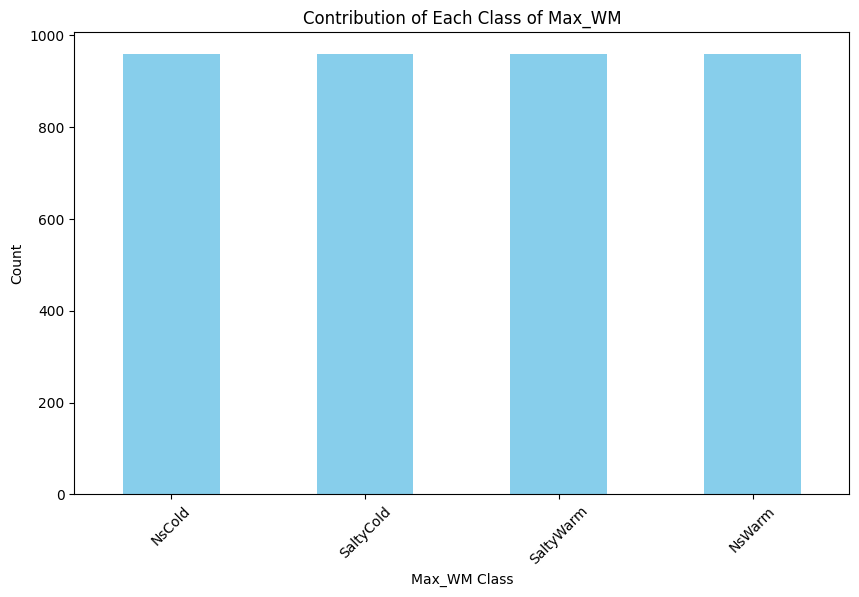

In [12]:
# Count the occurrences of each class in the "Max_WM" column
class_counts_b = balanced_df["WaterMass"].value_counts()
# Create a bar plot
plt.figure(figsize=(10, 6))
class_counts_b.plot(kind="bar", color="skyblue")
plt.title("Contribution of Each Class of Max_WM")
plt.xlabel("Max_WM Class")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

We then evaluate the spatial coverage of these datapoints and can assess that we are sampling most of the Arctic oceans, with some bias to the polar regions.

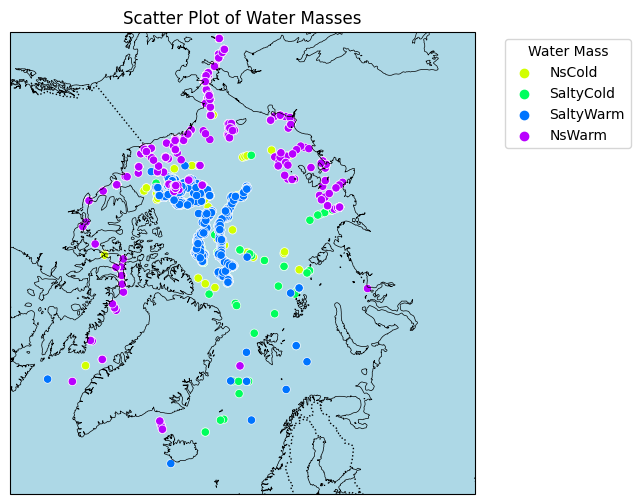

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and axis with a North Stereographic projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0.0))

# Set the extent to focus around the pole
ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())  # Adjust the latitudes as needed

# Add land outlines and color the sea
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.OCEAN, color='lightblue')  # Specify the color for the sea

# Scatter plot using seaborn with categorical colors
scatter = sns.scatterplot(
    data=balanced_df, x="longitude", y="latitude", hue="WaterMass",
    palette=sns.color_palette("hsv", n_colors=len(balanced_df["WaterMass"].unique())),
    transform=ccrs.PlateCarree(),  # Specify the map transformation
    ax=ax, legend="full"
)

# Customize the plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Scatter Plot of Water Masses")

# Add a legend
legend_labels = balanced_df["WaterMass"].unique()
handles, _ = scatter.get_legend_handles_labels()
ax.legend(handles, legend_labels, title="Water Mass", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

We then visualise the data in latitude, longitude and depth space in a 3D scatter plot. We can assess that generally, the water gets warmer as we get away from the pole and at lower latitude, as we might expect.
Moreover, at the pole (high latitude) we can see that there is cold and non salty water at the top and saltier water below. Interestingly, there is then this layer of warm and salty water at around 600m depth, possibly relating to the inflow of Atlantic water.

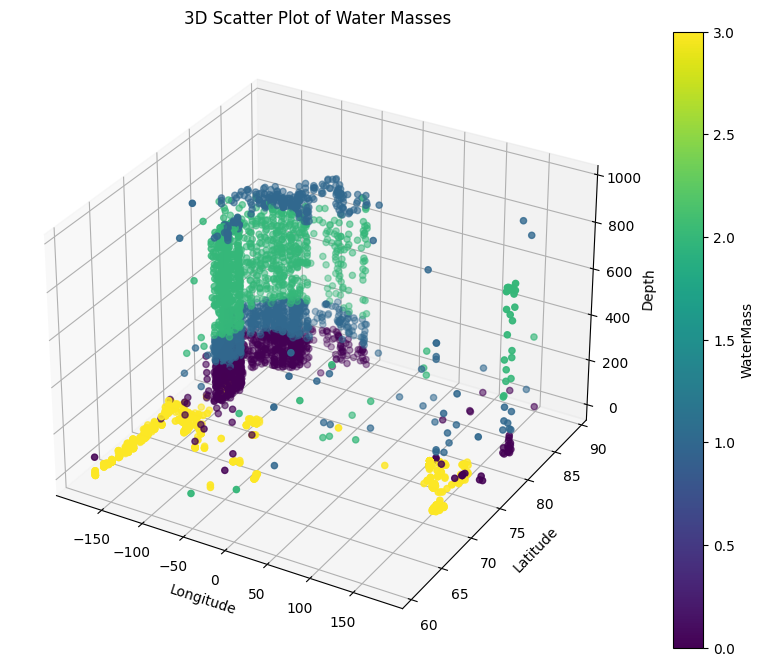

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Create a 3D scatter plot with categorical colors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Extract data
x = balanced_df["longitude"]
y = balanced_df["latitude"]
z = balanced_df["depth"]

# Convert categorical labels to numerical values for color-coding
max_wm_categories = balanced_df["WaterMass"].unique()
max_wm_mapping = {category: i for i, category in enumerate(max_wm_categories)}
hue = balanced_df["WaterMass"].map(max_wm_mapping)

# Use seaborn for categorical color-coding
scatter = ax.scatter(x, y, z, c=hue, cmap="viridis")

# Create a color bar to show the legend
legend = plt.colorbar(scatter, ax=ax, label="WaterMass")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth")
ax.set_title("3D Scatter Plot of Water Masses")

plt.show()


# Step 3: Domain expertise
From domain expertise, we can infer some initial assumptions. The factors we will consider are seasonality and the presence of sea ice.
### Seasonality
There is strong seasonality in the Arctic, where physical processes relating to sea ice formation and melt dictate the temperature and salinity properties of the water. When the ice forms, there is brine rejection, leaving the ocean salty as the ice forms of fresh water. In Summer therefore, we might expect less salty waters but also warmer waters in ice-forming regions.

### Sea ice
The presence of sea ice can prohibit the collection of datapoints in some conditions. Therefore, in Arctic data collection there is usually a significance bias towards collection in the Summer and Autumn. The data used for this experiment comes from ITP (Ice-Thethered Profile) data, so actually samples the water beneath this ice. We know that the presence of ice has an interesting impact on the water masses, as usually there is a cold layer of water (melt water) above the warmer Atlantic circulation at depth. The impact of the sea ice therefore is important, as well as the physical processes related to ice-ocean interaction.

We can look at the seasonality within our dataset.

In [16]:
# Define a function to map months to seasons
def map_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

# Apply the function to create a 'season' column
balanced_df['season'] = balanced_df['month'].apply(map_to_season)

We can see strong seasonality in our dataset, especially for the non-salty and warm waters, that only really occur in Summer and Autumn.

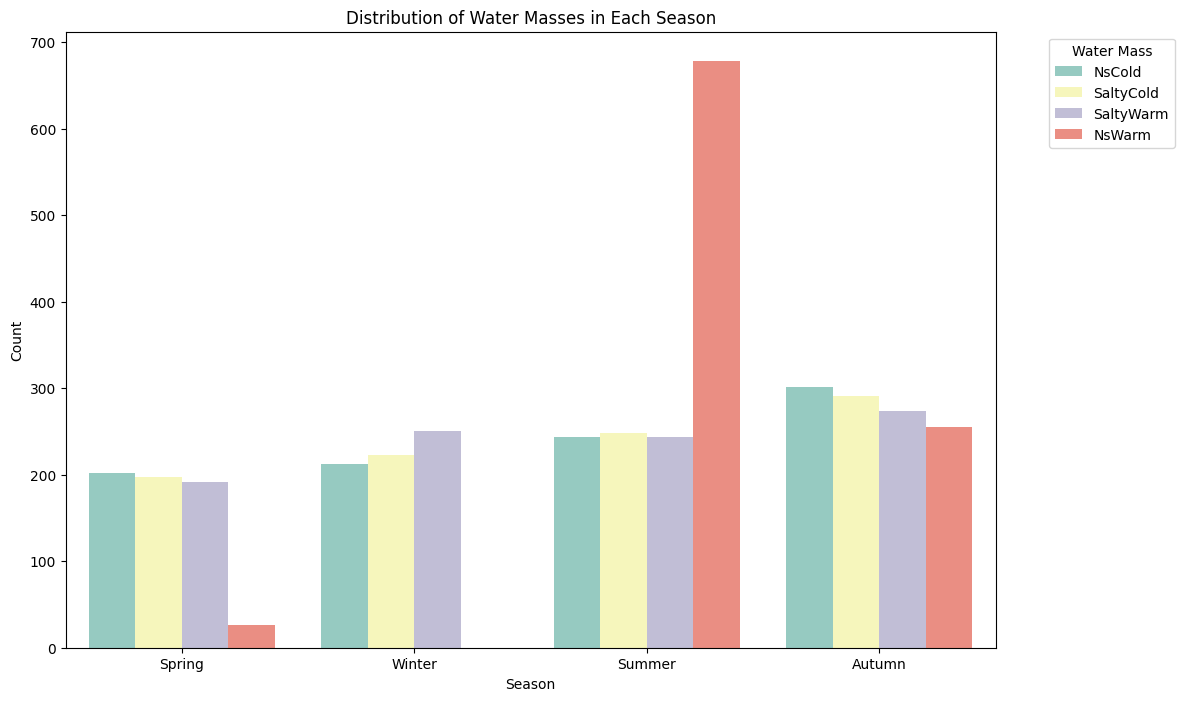

In [17]:
plt.figure(figsize=(12, 8))
sns.countplot(x="season", hue="WaterMass", data=balanced_df, palette="Set3")

plt.xlabel("Season")
plt.ylabel("Count")
plt.title("Distribution of Water Masses in Each Season")
plt.legend(title="Water Mass", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


### Feature analysis
- Around the Arctic, latitude and longitude become difficult, so transform cartesian coordinates to polar coordinates
- For time, we will consider the month as a feature as a seasonal sine component to implement seasonal variation. We assume there is a strong seasonal component to the temporal variation, not a linear monthly component.


First, convert latitude and longitude to r and theta (radius and angle from polar axis).

In [18]:
# Convert latitude and longitude degree units to radians
latitude_rad = np.radians(balanced_df['latitude'])
longitude_rad = np.radians(balanced_df['longitude'])

# Convert latitude to radial distance
balanced_df['r'] = 90 - balanced_df['latitude']

# Convert longitude to angular coordinate
balanced_df['theta'] = np.radians(balanced_df['longitude'])

# Convert theta to [0, 2*pi) range
balanced_df['theta'] = balanced_df['theta'] % (2 * np.pi)

### Change coordinate system
Since the pole is a point of convergence in the Cartesian or Polar coordinate system, a new system based on a reference point is created. This point is located at 50 deg latitude and -100 longitude, chosen arbitrarily. Then, the distance in metres towards that point is calculated using the haversine formula, and the bearing in degrees is calculated.

In [19]:
ref_latitude = 50
ref_longitude = -100

In [28]:
# Function to calculate angle between two points and the reference point
def calculate_angle(lat, lon):
  lat_rad, lon_rad = map(math.radians, [lat, lon])
  ref_lat_rad, ref_lon_rad = map(math.radians, [ref_latitude, ref_longitude])

  delta_lon = lon_rad - ref_lon_rad

  y = math.sin(delta_lon) * math.cos(lat_rad)
  x = math.cos(ref_lat_rad) * math.sin(lat_rad) - (math.sin(ref_lat_rad) * math.cos(lat_rad) * math.cos(delta_lon))

  angle_rad = math.atan2(y, x)
  angle_deg = math.degrees(angle_rad)
  return angle_deg

# Calculate angle for each point in the DataFrame
balanced_df['bearing'] = balanced_df.apply(lambda row: calculate_angle(row['latitude'], row['longitude']), axis=1)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Calculate distances from each point to the reference point
balanced_df['distance'] = haversine(ref_latitude, ref_longitude, balanced_df['latitude'], balanced_df['longitude'])

# Assuming 'balanced_df' already contains a 'month' column
balanced_df['seasonal_sin'] = np.sin(2 * np.pi * balanced_df['month'] / 12)

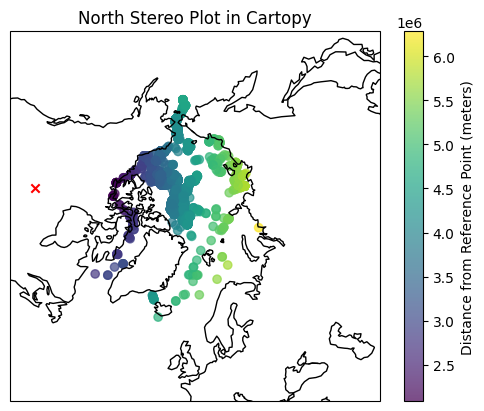

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Create a Cartopy plot with a North Polar Stereo projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()})
sc = ax.scatter(balanced_df['longitude'], balanced_df['latitude'], c=balanced_df['distance'], cmap='viridis', alpha=0.7, transform=ccrs.PlateCarree())

# Plot the reference point
ax.scatter(ref_longitude, ref_latitude, color='red', marker='x', label='Reference Point', transform=ccrs.PlateCarree())

# Customize the plot
ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())  # Set the extent for the North Polar Stereo projection
ax.coastlines()

# Add a colorbar
cbar = fig.colorbar(sc, ax=ax, label='Distance from Reference Point (meters)')

# Add a title
plt.title('North Stereo Plot in Cartopy')

# Show the plot
plt.show()


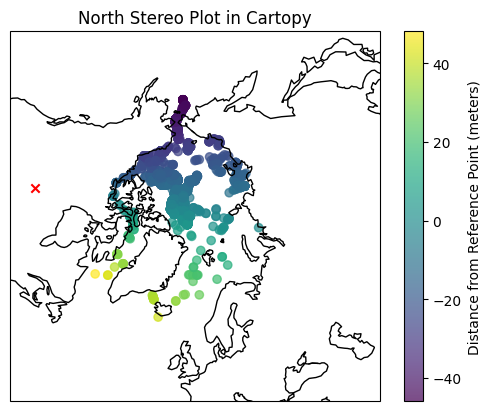

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Create a Cartopy plot with a North Polar Stereo projection
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()})
sc = ax.scatter(balanced_df['longitude'], balanced_df['latitude'], c=balanced_df['bearing'], cmap='viridis', alpha=0.7, transform=ccrs.PlateCarree())

# Plot the reference point
ax.scatter(ref_longitude, ref_latitude, color='red', marker='x', label='Reference Point', transform=ccrs.PlateCarree())

# Customize the plot
ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())  # Set the extent for the North Polar Stereo projection
ax.coastlines()

# Add a colorbar
cbar = fig.colorbar(sc, ax=ax, label='Distance from Reference Point (meters)')

# Add a title
plt.title('North Stereo Plot in Cartopy')

# Show the plot
plt.show()


secondly, use a sine function to cover the seasonal time aspect

In [32]:
# Assuming 'balanced_df' already contains a 'month' column
balanced_df['seasonal_sin'] = np.sin(2 * np.pi * balanced_df['month'] / 12)

## Look at scale
Predictors for the model will be latitude, longitude, depth and time. Look at the distribution of these parameters to look at the scale and define a prior later (step 7).

Domain knowledge: typical scale of water masses in the Arctic is difficult as there is high spatial variability. Distances are approximately 100-500 kilometers.

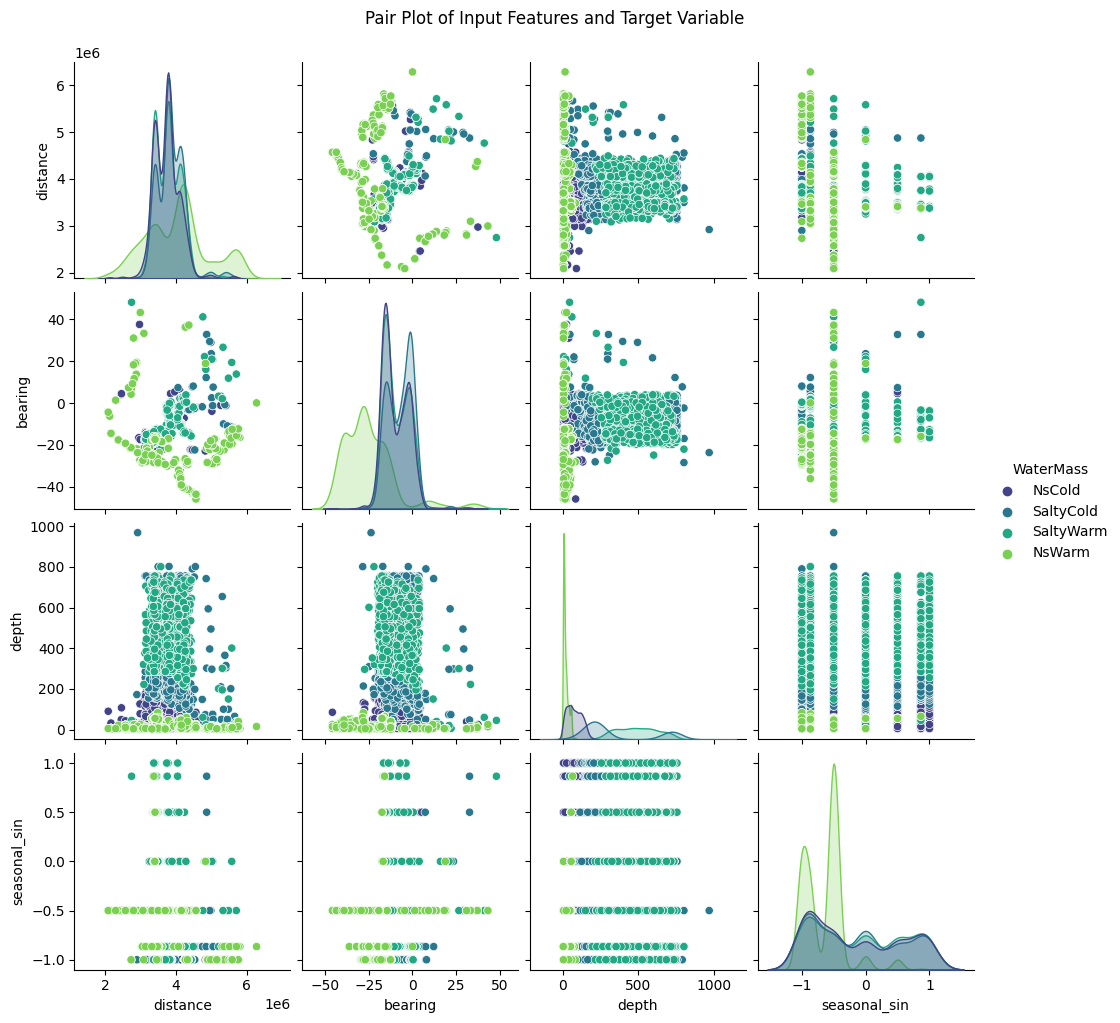

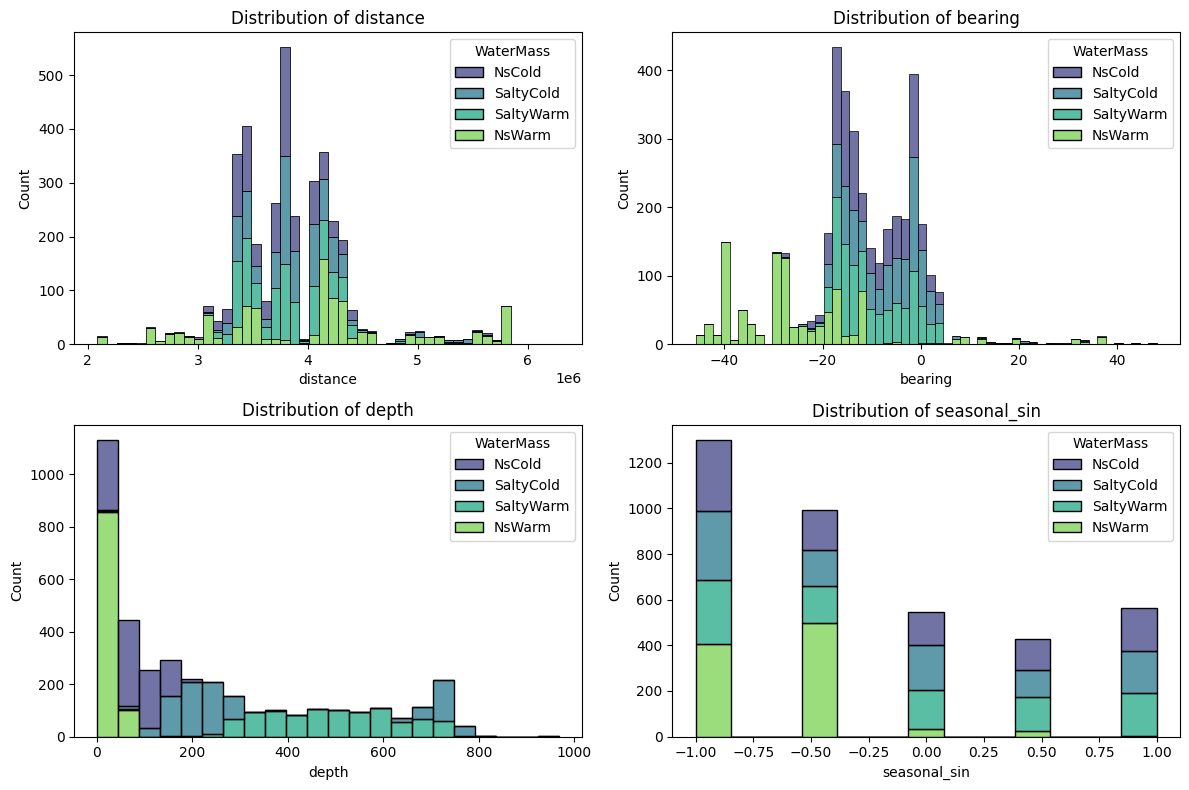

In [33]:
# Select the features and target variable
features = ['distance', 'bearing', 'depth', 'seasonal_sin']
target = 'WaterMass'

# Concatenate the features and target into a single DataFrame
plot_data = pd.concat([balanced_df[features], balanced_df[target]], axis=1)

# Pair plot to visualize relationships
sns.pairplot(plot_data, hue=target, palette='viridis')
plt.suptitle('Pair Plot of Input Features and Target Variable', y=1.02)
plt.show()

# Plot distributions of input features
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=plot_data, x=feature, hue=target, multiple="stack", palette='viridis')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [34]:
feature_stats = balanced_df[['distance', 'bearing', 'depth', 'seasonal_sin']].describe().transpose()

# Additional calculation for range
feature_stats['range'] = feature_stats['max'] - feature_stats['min']

# Display the computed statistics
print(feature_stats)

               count          mean            std           min           25%  \
distance      3836.0  3.854788e+06  564624.120939  2.087309e+06  3.454067e+06   
bearing       3836.0 -1.272088e+01      12.323490 -4.585366e+01 -1.746251e+01   
depth         3836.0  2.318171e+02     237.362311  1.000000e+00  2.600000e+01   
seasonal_sin  3836.0 -2.512519e-01       0.667038 -1.000000e+00 -8.660254e-01   

                       50%           75%           max         range  
distance      3.797941e+06  4.139322e+06  6.283400e+06  4.196091e+06  
bearing      -1.305063e+01 -3.677002e+00  4.808349e+01  9.393715e+01  
depth         1.450000e+02  3.850000e+02  9.680000e+02  9.670000e+02  
seasonal_sin -5.000000e-01  5.000000e-01  1.000000e+00  2.000000e+00  


We then assess the correlations between the features, which provides insights into the dependency and relationships of features within our data.
Moreover, this can enhance interpretability of the Gaussian Process model.

Moreover, in a model with features with high dependency, a Matern or RBF kernel would be more suitable. It can also inform hyperparameter tuning.

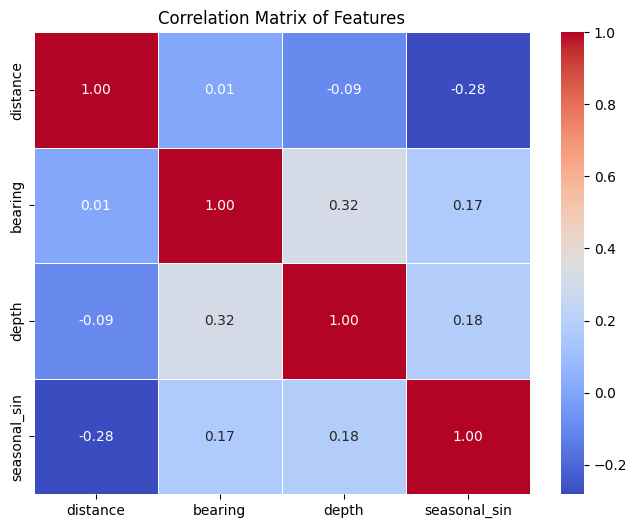

In [35]:
# Calculate the correlation matrix
correlation_matrix = balanced_df[['distance', 'bearing', 'depth', 'seasonal_sin']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Display the plot
plt.title("Correlation Matrix of Features")
plt.show()



Set priors for the length scales of the GP kernel.

r Feature:
- The range of the 'r' feature is quite large (28.784000), and it has a moderate negative correlation with 'depth'.
- A prior for the length scale to capture the variability.

theta Feature:
- The range of the 'theta' feature is smaller (6.283081), and it has weak correlations with other features.
- A prior with a smaller scale may be appropriate, given the smaller range.

depth Feature:
-The 'depth' feature has a wide range (999.000000) and shows weak correlations with other features.
- A prior that accommodates the wide range could be suitable.

seasonal_sin Feature:
- The 'seasonal_sin' feature has a range of 2.000000 and shows weak correlations with other features.
- A smaller scale prior might be appropriate here.

# 4. Training, validation and test set definition

As we are doing interpolation, we would still want all basins within the Arctic to be featured in the training dataset. Use k nearest neighbours to create clusters within different regions and then randomly put those in train and test. I basically want to sample much in my training dataset but don't want it to include neighbouring points.

Cluster using k-Nearest-Neighbours based on latitude and longitude.

In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

n_clusters_per_region = 80

# Use KMeans for clustering within each region
kmeans_clusters = KMeans(n_clusters=n_clusters_per_region, n_init=n_clusters_per_region, random_state=7)
balanced_df['cluster'] = kmeans_clusters.fit_predict(balanced_df[['latitude', 'longitude']])

# Determine which clusters to assign to train, val, and test
cluster_indices = balanced_df['cluster'].unique()

# Assuming 'cluster' is the column containing cluster labels in balanced_df
clusters = balanced_df['cluster'].unique()

# Split clusters into training and validation sets
train_clusters, split_clusters = train_test_split(clusters, test_size=0.3, random_state=42)
val_clusters, test_clusters = train_test_split(split_clusters, test_size=0.4, random_state=42)

# Create training and validation datasets
train_dataset = balanced_df[balanced_df['cluster'].isin(train_clusters)]
val_dataset = balanced_df[balanced_df['cluster'].isin(val_clusters)]
test_dataset = balanced_df[balanced_df['cluster'].isin(test_clusters)]

# Verify the size of each dataset
print("Train Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))

Train Dataset Size: 2497
Validation Dataset Size: 592
Test Dataset Size: 747


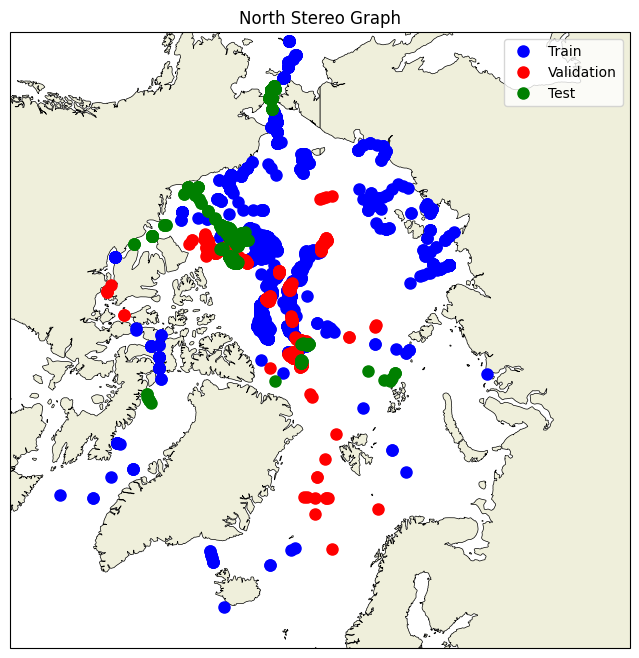

In [15]:
# Create a north polar stereographic projection
projection = ccrs.NorthPolarStereo()

# Plot the datasets on a north stereo graph
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(8, 8))
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

# Add land contours
ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5)

# Plot points for each dataset with different colors
ax.plot(train_dataset['longitude'], train_dataset['latitude'], 'bo', markersize=8, transform=ccrs.PlateCarree(), label='Train')
ax.plot(val_dataset['longitude'], val_dataset['latitude'], 'ro', markersize=8, transform=ccrs.PlateCarree(), label='Validation')
ax.plot(test_dataset['longitude'], test_dataset['latitude'], 'go', markersize=8, transform=ccrs.PlateCarree(), label='Test')

# Add legend and title
ax.legend()
ax.set_title('North Stereo Graph')

# Show the plot
plt.show()